Unit found but no mnemonic keyword matched.
Curves with matched unit(s) (US/FT):
1: Mnemonic: DT_E, Unit: US/FT
Select a curve (1-1) or 0 to skip: 1


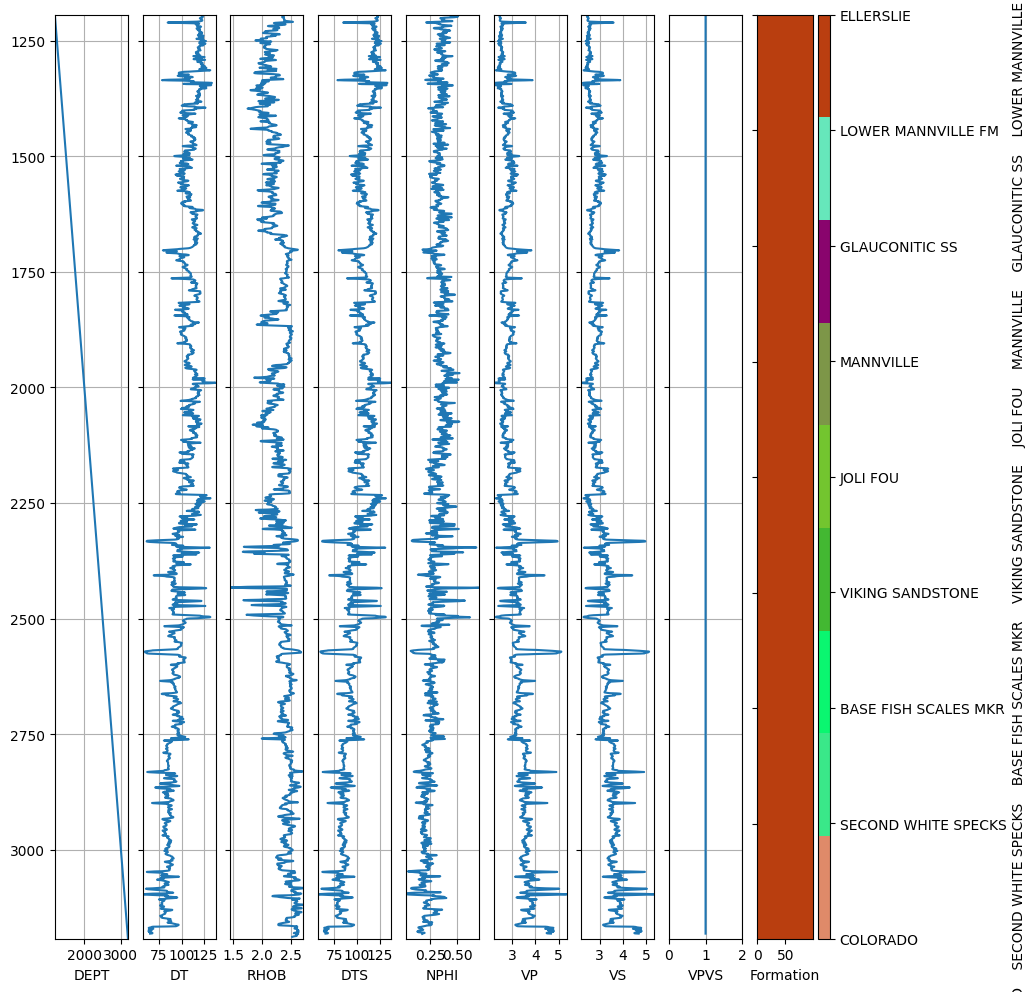

ValueError: Axis limits cannot be NaN or Inf

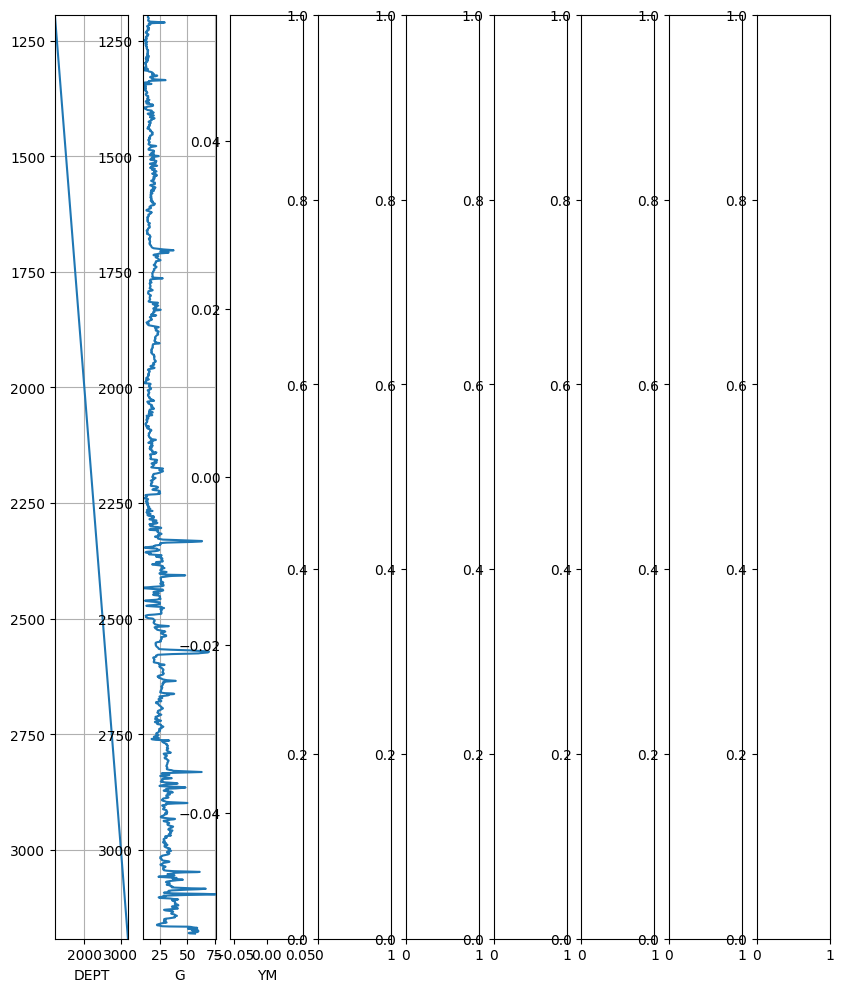

In [3]:
import pandas as pd
import sys
from sys import stdout
import lasio
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None
%matplotlib inline
lithology_dict = {
    3120: "SSH", 3000: "S", 7100: "SH", 1600: "SHS", 3360: "SSH", 6860: "SH",
    2180: "S", 1860: "SHS", 2060: "SH", 2480: "SSH", 7200: "LSSH", 6780: "LS",
    2140: "SSH", 6580: "LSSH", 3100: "SSH", 7280: "LS", 1400: "SSS", 2360: "SSH",
    1340: "S", 2800: "S", 7440: "LS", 6960: "LS", 3340: "SSH", 7320: "LS",
    7170: "SH", 3500: "S", 2440: "SSH", 2400: "SSH", 1000: "LS", 2420: "S",
    2600: "SSS", 2000: "S", 7200: "LS", 2810: "S"
}
# Define mnemonics and units
DT_mnemonic = ['DT']
DT_units = ['US/FT']
DEPT_mnemonic = ['DEPT', 'DEPTH']
DEPT_units = ['FT', 'M']
DTS_mnemonic = ['DTS', 'DTSH']
DTS_units = ['US/FT']
RHOB_mnemonic = ['RHOB']
RHOB_units = ['G/CC','kg/m3','g/cm3']
NPHI_mnemonic = ['NPHI']
NPHI_units = ['V/V']

def get_formation_and_tops(las_file_path):
    las = lasio.read(las_file_path)
    well_name = las.well['API'].value
    filtered_data = formationtops[formationtops['API_UWI_12'] == well_name]
    if filtered_data.empty:
        return las, pd.DataFrame(columns=['FormationName', 'MD_Top', 'FormationCode', 'MD_Bottom', 'LithoCode'])
    formation_details = filtered_data[['FormationName', 'MD_Top', 'FormationCode']]
    formation_details = formation_details.sort_values(by='MD_Top', ascending=True)
    formation_details['MD_Bottom'] = formation_details['MD_Top'].shift(-1)
    formation_details['LithoCode'] = formation_details['FormationCode'].map(lithology_dict).fillna('None')
    depth_unit = las.curves['DEPT'].unit.lower() 
    if depth_unit == 'ft':
        max_depth = las.depth_ft.max()
    elif depth_unit == 'm':
        max_depth = las.depth_m.max()
    else:
        raise ValueError(f"Unexpected depth unit: {depth_unit}")
    formation_details.at[formation_details.index[-1], 'MD_Bottom'] = max_depth
    return las, formation_details
def select_curve(las, mnemonic_keywords, units):
    matched_curves = []
    for curve in las.curves:
        for keyword in mnemonic_keywords:
            for unit in units:
                if keyword in curve.mnemonic and curve.unit == unit:
                    matched_curves.append(curve)
    if len(matched_curves) > 1:
        print("Multiple mnemonic keywords matched with the provided units:")
        for i, curve in enumerate(matched_curves):
            print(f"{i+1}: Mnemonic: {curve.mnemonic}, Unit: {curve.unit}")
        
        choice = int(input(f"Select a curve (1-{len(matched_curves)}) or 0 to skip: "))
        if choice > 0 and choice <= len(matched_curves):
            return matched_curves[choice-1].mnemonic
        else:
            return None
    elif len(matched_curves) == 1:
        return matched_curves[0].mnemonic
    matched_unit_curves = []
    for curve in las.curves:
        if curve.unit in units:
            matched_unit_curves.append(curve)
    if matched_unit_curves:
        print("Unit found but no mnemonic keyword matched.")
        print(f"Curves with matched unit(s) ({', '.join(units)}):")
        for i, curve in enumerate(matched_unit_curves):
            print(f"{i+1}: Mnemonic: {curve.mnemonic}, Unit: {curve.unit}")        
        choice = int(input(f"Select a curve (1-{len(matched_unit_curves)}) or 0 to skip: "))
        if choice > 0 and choice <= len(matched_unit_curves):
            return matched_unit_curves[choice-1].mnemonic
        else:
            return None
    return None
def Calculate_mechanical_Prop(las, formation_details):
    DEPT = select_curve(las, DEPT_mnemonic, DEPT_units)
    DT = select_curve(las, DT_mnemonic, DT_units)
    RHOB = select_curve(las, RHOB_mnemonic, RHOB_units)
    DTS = select_curve(las, DTS_mnemonic, DTS_units)
    NPHI = select_curve(las, NPHI_mnemonic, NPHI_units)
    selected_logs = {}
    if DEPT: selected_logs['DEPT'] = DEPT
    if DT: selected_logs['DT'] = DT
    if RHOB: selected_logs['RHOB'] = RHOB
    if DTS: selected_logs['DTS'] = DTS
    if NPHI: selected_logs['NPHI'] = NPHI    
    if not selected_logs:
        raise ValueError("No valid curves selected. Cannot proceed with mechanical property calculations.")
    WellLogDf = las.df().reset_index()  
    try:
        logData = WellLogDf[selected_logs.values()].copy()
    except KeyError as e:
        raise KeyError(f"Error selecting curves from LAS file: {e}")  
    logData.columns = selected_logs.keys()
    if DT_units == 'US/FT':
        logData['DT'] *= 3.281 
    if DTS_units == 'US/FT' and 'DTS' in logData.columns:
        logData['DTS'] *= 3.281
    if RHOB_units == 'KG/M3':
        logData['RHOB'] *= 0.001  
    if 'DT' in logData.columns:
        logData['VP'] = 304.8 / logData['DT']  
    if 'DTS' in logData.columns and logData['DTS'].notna().any():
        logData['VS'] = 304.8 / logData['DTS']
    elif 'VP' in logData.columns:
        logData['VS'] = None
        for index, row in logData.iterrows():
            matching_rows = formation_details.loc[
                (formation_details['MD_Top'] <= row['DEPT']) & (row['DEPT'] <= formation_details['MD_Bottom']),
                'LithoCode']
            if not matching_rows.empty:
                Lith = matching_rows.values[0]
            else:
                Lith = 'None' 
            if Lith in ['SS', 'SOG', 'S', 'SSS', 'SO', 'SCO', 'SG']:
                logData.at[index, 'VS'] = (0.8042 * row['VP'] - 855.9)/1000
            elif Lith == 'LS':
                logData.at[index, 'VS'] = (1.0168 * row['VP'] - 0.00005509 * row['VP']**2 - 1030.5)/1000
            elif Lith == 'DOL':
                logData.at[index, 'VS'] = (0.5832 * row['VP'] - 77.76)/1000
            elif Lith in ['SHOG', 'SH','SSH','SHS']:
                logData.at[index, 'VS'] = (0.77 * row['VP'] - 867.4)/1000    
    if 'VP' in logData.columns and 'VS' in logData.columns:
        logData['VPVS'] = logData['VP'] / logData['VS']  
    logData['Formation'] = None 
    logData['Lithology'] = None
    logData['Formation Code'] = None
    for index, row in logData.iterrows():
        depth = row['DEPT']
        mask = (formation_details['MD_Top'] <= depth) & (depth <= formation_details['MD_Bottom'])
        matching_row = formation_details[mask]
        if not matching_row.empty:
            logData.at[index, 'Formation Code'] = matching_row.iloc[0]['FormationCode']
            logData.at[index, 'Lithology'] = matching_row.iloc[0]['LithoCode']
            logData.at[index, 'Formation'] = matching_row.iloc[0]['FormationName']
    logData = logData[logData['Lithology'].notna()]  
    MechProp = pd.DataFrame()
    MechProp['DEPT'] = logData['DEPT'].copy()
    MechProp['Formation Code'] = logData['Formation Code'].copy()
    MechProp['Formation'] = logData['Formation'].copy()
    MechProp['G'] = (logData['RHOB']) * (logData['VP'] ** 2)
    MechProp['YM'] = ((logData['RHOB']) * logData['VS']**2 * (3*logData['VP']**2) - 4*logData['VS']**2) / (logData['VP']**2 - logData['VS']**2)
    MechProp['PRa'] = ((logData['VP']**2) - 2*(logData['VS']**2)) / (2*((logData['VP']**2) - (logData['VS']**2)))
    MechProp['K'] = (logData['RHOB'] * 0.001) * ((logData['VP']**2) - ((4/3) * (logData['VS']**2)))
    UCS, Coh, FA = [], [], []
    for index, row in logData.iterrows():
        Lith = row['Lithology']
        if Lith == 'SHOG' or Lith == 'SH':
            ucs = 1.35 * (304.8 / (row['DT'] / 3.281))**2.6
            coh = 0.02 * np.exp(0.002 * (1000 * (row['VP'])))
            fa = math.degrees(math.asin((1000*row['VP']-1000) / (1000*row['VP']+1000)))
        elif Lith in ['SS', 'SOG', 'S', 'SSS', 'SO', 'SCO', 'SG']:
            ucs = 0.035 * (1000 * row['VP']) - 31.5
            fa = 57.8 - 105 * row['NPHI']
            coh = ucs / (2 * math.tan(math.radians(45 + (fa / 2))))
        else:
            ucs = ((7682 / ((row['DT']) / 3.281)**1.82)) / 145
            coh = 0.02 * np.exp(0.002 * (1000 * row['VP']))
            fa = math.degrees(math.asin((1000 * row['VP'] - 1000) / (1000 * row['VP'] + 1000)))
        UCS.append(ucs)
        Coh.append(coh)
        FA.append(fa)
    MechProp['UCS'] = UCS
    MechProp['Coh'] = Coh
    MechProp['FA'] = FA
    numeric_cols = ['G', 'YM', 'PRa', 'K', 'UCS', 'Coh', 'FA']
    MechProp[numeric_cols] = MechProp[numeric_cols].apply(pd.to_numeric, errors='coerce')
    return MechProp, logData
def calculate_mechanical_properties_mean(MechProp):
    MechPropMean = pd.DataFrame()
    MechPropMean['DEPT'] = MechProp['DEPT'].copy()
    meanG = MechProp.groupby('Formation Code')['G'].transform('mean')
    meanYM = MechProp.groupby('Formation Code')['YM'].transform('mean')
    meanPRa = MechProp.groupby('Formation Code')['PRa'].transform('mean')
    meanK = MechProp.groupby('Formation Code')['K'].transform('mean')
    meanUCS = MechProp.groupby('Formation Code')['UCS'].transform('mean')
    meanCoh = MechProp.groupby('Formation Code')['Coh'].transform('mean')
    meanFA = MechProp.groupby('Formation Code')['FA'].transform('mean')
    MechPropMean['Formation Code'] = MechProp['Formation Code']
    MechPropMean['G'] = meanG
    MechPropMean['YM'] = meanYM
    MechPropMean['PRa'] = meanPRa
    MechPropMean['K'] = meanK
    MechPropMean['UCS'] = meanUCS
    MechPropMean['Coh'] = meanCoh
    MechPropMean['FA'] = meanFA
    return MechPropMean
def create_facies_plot(log_data, formation_details):
    log_data['Formation Code'] = log_data['Formation Code'].astype('int')   
    num_formations = len(formation_details)
    facies_colors = np.random.rand(num_formations, 3)  
    facies_labels = formation_details.FormationName.to_list()
    facies_color_map = {label: facies_colors[ind] for ind, label in enumerate(facies_labels)}
    def label_facies(row, labels):
        formation_index = int(row['Formation Code']) - 1
        if 0 <= formation_index < len(labels):
            return labels[formation_index]
        else:
            return 'Unknown'
    log_data['FaciesLabels'] = log_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
    def make_facies_log_plot(logs, facies_colors):
        logs = logs.dropna(subset=['Formation Code'])
        logs['Formation Code'] = logs['Formation Code'].astype(int)
        logs = logs.sort_values(by='DEPT')
        cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
        ztop = logs.DEPT.min()
        zbot = logs.DEPT.max()
        cluster = np.repeat(np.expand_dims(logs['Formation Code'].values, 1), 100, 1).astype(int)
        numeric_cols = logs.select_dtypes(include=np.number).columns.tolist()
        numeric_cols.remove('Formation Code')
        num_plots = len(numeric_cols)  
        f, ax = plt.subplots(nrows=1, ncols=num_plots + 1, figsize=(10, 12))
        for col_idx, col in enumerate(numeric_cols):
            ax[col_idx].plot(logs[col], logs.DEPT, '-')
            ax[col_idx].set_xlabel(col)
            x_min, x_max = logs[col].min(), logs[col].max()
            if x_min == x_max:
                ax[col_idx].set_xlim(x_min - 1, x_max + 1) 
            else:
                ax[col_idx].set_xlim(x_min, x_max)
            ax[col_idx].locator_params(axis='x', nbins=3)
            ax[col_idx].set_ylim(ztop, zbot)
            ax[col_idx].invert_yaxis()
            ax[col_idx].grid()
        im = ax[-1].imshow(cluster, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=1, vmax=len(facies_colors))
        divider = make_axes_locatable(ax[-1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label((1 * '    ').join(facies_labels))
        cbar.set_ticks(range(1, len(facies_labels) + 1))
        cbar.set_ticklabels(facies_labels)
        ax[-1].set_xlabel("Formation")
        for i in range(1, len(ax)):
            ax[i].set_yticklabels([])
        plt.show()
    make_facies_log_plot(log_data, facies_colors)
las_file_path = '100121906024W400_ECP_RS0046046885.las'
formationtops = pd.read_csv('env_csv-FormationTops-80a2b_2024-05-12.csv')
las, formation_details = get_formation_and_tops(las_file_path)
formation_details
MechProp, logData = Calculate_mechanical_Prop(las, formation_details)
create_facies_plot(logData,formation_details)
create_facies_plot(MechProp,formation_details)
MechPropMean=calculate_mechanical_properties_mean(MechProp)
create_facies_plot(MechPropMean,formation_details)
#MechProp.groupby('Formation').agg('mean').reset_index()